In [ ]:
#IMPORT LIBRARIES
import time
from typing import KeysView

from selenium import webdriver
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from selenium.webdriver.common.keys import Keys

import openpyxl as xl
import pandas as pd

from getpass import getuser

In [ ]:
#CONFIG WEBDRIVER OPTIONS
options=webdriver.ChromeOptions()
options.add_argument(r'--user-data-dir=C:/Users/{}/AppData/Local/Google/Chrome/User DataDefault'.format(getuser()))
options.add_argument('--profile-directory=Default')
#options.add_argument('--headless')

#INSTANCE WEBDRIVER
chrome_browser=webdriver.Chrome(executable_path=r'C:/Users/{}/VscodeFiles/python/infosTj/driver/chromedriver.exe'.format(getuser()),options=options) 

In [ ]:
#SURF TO WEB
chrome_browser.get('https:www.jw.org/es/biblioteca/libros')

#LIST: Write Content
years=['2017','2018','2019','2020','2021'] #value of <option> is equal to 'syrnn' where nn=two last digits of year. 
for year in years:
    
    #LIST: Identify Webelements
    input =WebDriverWait(chrome_browser,10).until(EC.presence_of_element_located((By.XPATH, '//input[@id="pubFilter"]')))
    inputClick=WebDriverWait(chrome_browser, 15).until(EC.element_to_be_clickable(input)); #The class Select doesn't work
    input.click()
    input.send_keys(Keys.CLEAR)
    input.click()
    
    #FILTER year, because the publications names by years are differents
    if year=='2017'or year=='2018':
        input.send_keys("Informe mundial del año de servicio de los testigos de Jehová {}".format(year))
    else:
        input.send_keys("Informe mundial de los testigos de Jehová del año de servicio {}".format(year))
    input.send_keys(Keys.ENTER)

    #LIST: Send Content(SEARCH)
    chrome_browser.find_element(By.XPATH, '//input[@value="Buscar"]').click()

    #PUBLICATION
    pubDiv =WebDriverWait(chrome_browser,10).until(EC.presence_of_element_located((By.XPATH, '//div[@class="publicationDesc"]'))) #clickable(?)
    pub=chrome_browser.find_element(By.XPATH, '//div[@class="publicationDesc"]').click()

    #PUBLICATION CONTENT
    pubContentDiv =WebDriverWait(chrome_browser,10).until(EC.presence_of_element_located((By.XPATH, '//div[@class="syn-body sqs   "]'))) #clickable(?)
    if year=='2017':
        infoBuscar='Informe por países y territorios del'+'''\u00a0'''+year
        print(infoBuscar)
    else:
        infoBuscar='Informe del {} por países y territorios'.format(year) #use find_by_link_text
    chrome_browser.find_element(By.XPATH, '//a[contains(text(), "{}")]'.format(infoBuscar)).click()

    #GET TABLE VALUES
    WebDriverWait(chrome_browser,10).until(EC.presence_of_element_located((By.XPATH, '//div[@class="tableDiv stripe wide gridlines"]')))

    rows=chrome_browser.find_elements(By.TAG_NAME,'tr') 
    cols=chrome_browser.find_elements(By.TAG_NAME,'th')
    

    #Shape
    rowsCount=len(rows) #not include +1 what is head
    colsCount=len(cols)
    print(str(rowsCount+1)+"x"+str(colsCount))

    #Heads, ie, columns titles
    globals()['mc'+year]=[]
    for i in range(0,colsCount):
        globals()['mc'+year].append(cols[i].text)

    #rows
    globals()['mr'+year]=[]
    for i in range(1,rowsCount):
        r=[]
        row=rows[i]
        for j in range(0,colsCount):
            col=row.find_elements(By.TAG_NAME,'td')[j]
            r.append(col.text)
        globals()['mr'+year].append(r)
        
    #UP LEVEL
    chrome_browser.get('https:www.jw.org/es/biblioteca/libros')

In [ ]:
mr2020

In [26]:
#WRITE IN DATAFRAME

#REPLACE "." (PERIOD) POR "" in sequence...
def replacePeriod(fila):
    for c in globals()['mc'+year]:
        characters="."
        for x in range(0,len(characters)):
            if characters[x] in fila[c]:
                fila[c]=fila[c].replace(characters[x],"")

#...in sequenceREPLACE "," (PERIOD) FOR "."
def replaceComma(fila):
    for c in globals()['mc'+year]:
        characters=","
        for x in range(0,len(characters)):
            if characters[x] in fila[c]:
                fila[c]=fila[c].replace(characters[x],".")

years=['2017','2018','2019','2020'] #nowasdays mc2021 exclude

for year in years:
    #dataframe data is mr, header is mc
    globals()['df'+year]=pd.DataFrame(data=globals()['mr'+year], columns=globals()['mc'+year])
    #print(df)
    #print(df.loc[range(0,5),mc[1:5]]) #in loc put rows in int list and columns in list string
    #print(mc[1:]) #names columns with numbers
    
    #REPLACE /n with 0 #ALERT!!!!!!!!
    globals()['df'+year]=globals()['df'+year].replace(r'^\s*$', '0', regex=True)
    globals()['df'+year].apply(replacePeriod,axis=1)
    globals()['df'+year].apply(replaceComma,axis=1)


    #CHANGE TYPE OF NUMERICS COLUMNS
    globals()['df'+year][globals()['mc'+year][1:]]=globals()['df'+year][globals()['mc'+year][1:]].astype(float)
    
    
    #INDEX WILL BE COUNTRY NAME
    for i in range(0,globals()['df'+year].shape[0]):
        globals()['df'+year]=globals()['df'+year].rename(index={globals()['df'+year].index[i]:globals()['df'+year][globals()['mc'+year][0]][i]})
    globals()['df'+year]=globals()['df'+year].drop(columns=globals()['mc'+year][0])

In [27]:
#SAVE DATAFRAMES
df2017.to_csv('df2017.csv')
df2018.to_csv('df2018.csv')
df2019.to_csv('df2019.csv')
df2020.to_csv('df2020.csv')

In [ ]:
#LOAD DATAFRAMES FROM CSV
df2017=pd.read_csv('df2017.csv', index_col="Unnamed: 0")
df2018=pd.read_csv('df2018.csv', index_col="Unnamed: 0")
df2019=pd.read_csv('df2019.csv', index_col="Unnamed: 0")
df2020=pd.read_csv('df2020.csv', index_col="Unnamed: 0")

df2017

In [ ]:
#VISUALIZE DF #TODO: PRETTIER PANDAS!!!!!!!! 03/01/2022 2140
df2017Col=df2017.loc['Colombia']
df2018Col=df2018.loc['Colombia']
df2019Col=df2019.loc['Colombia']
df2020Col=df2020.loc['Colombia']


In [ ]:
df2017Col.shape #9 rows 1 columns

#REMOVE NUMBERS OF COLUMNS-NAMES (ALL COLUMNS SHOULD HAVE THE SAME NAMES). USE globals(): TODO FOR ONLY ONE, THEN FOR ALL

#FOR ONLY ONE... It doesn't works because mc2017 it defined in block: get data drom web
characters = "0126789"
mc2017n=[]

#for c2017 in mc2017:
    #for c in characters:
        #c2017=c2017.replace(c,"")
    #mc2017n.append(c2017) #Array with columns-names without numbers (years)
#df2017Col=df2017Col.rename(index={c2017:c2017n for (c2017,c2017n) in zip(mc2017,mc2017n)})

#...FOR ALL
characters = "0126789"
years=['2017','2018','2019','2020']
for year in years:
    globals()['mc'+year]=globals()['df'+year].columns
    globals()['mc'+year+'n']=[]
    for cyear in globals()['mc'+year]:
        for char in characters:
            cyear=cyear.replace(char,"")
        globals()['mc'+year+'n'].append(cyear) #Array with columns-names without numbers (years)
    globals()['df'+year+'Col']=globals()['df'+year+'Col'].rename(index={cyear:c2020n for (cyear,c2020n) in zip(globals()['mc'+year],globals()['mc'+year+'n'])})
    
df2017Col=df2017Col.rename(index={mc2017[3]:'Un publicador por cada'}) #Change the name of a column
df2017Col
df2018Col=df2018Col.rename(index={mc2018[3]:'Un publicador por cada'}) #Change the name of a column
df2018Col

df2019Col
df2020Col

dfColombia=pd.DataFrame(index=['2017','2018','2019','2020'],data=[df2017Col,df2018Col,df2019Col,df2020Col])
dfColombia

In [ ]:
import matplotlib.pyplot as plt

dfColombia['Máximo de publicadores en '].plot(kind='line',color='red',marker='o',linestyle='dashed',legend='Max. Pub')
plt.title('Testigos de Jehová en Colombia ['+years[0]+'-'+years[3]+']')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint

plt.rcParams.update({
    "font.weight": "bold",
    "xtick.major.size": 5,
    "xtick.major.pad": 7,
    "xtick.labelsize": 15,
    "grid.color": "0.5",
    "grid.linestyle": "-",
    "grid.linewidth": 0.5,
    "lines.linewidth": 2,
    "lines.color": "g",
})
markers = ['\\alpha', '\\beta', '\gamma', '\sigma','\infty', \
            '\spadesuit', '\heartsuit', '\diamondsuit', '\clubsuit', \
            '\\bigodot', '\\bigotimes', '\\bigoplus', '\imath', '\\bowtie', \
            '\\bigtriangleup', '\\bigtriangledown', '\oslash' \
           '\ast', '\\times', '\circ', '\\bullet', '\star', '+', \
            '\Theta', '\Xi', '\Phi', \
            '\$', '\#', '\%', '\S'] #If writ r'... the last list doesn't neccessary
dfColombia['Promedio de precursores'].plot(kind='line',alpha=0.5,color='green',marker=r'$\Theta$',markersize=randint(2,30,1),linestyle='dashed',legend='Max. Pub')
plt.title('Testigos de Jehová en Colombia ['+years[0]+'-'+years[3]+']')
plt.grid(visible=True)

plt.show()

In [ ]:
dfColombia['Asistencia a la Conmemoración'].plot(kind='line',color='blue',marker='*',legend='Asis. Conm')
plt.title('Testigos de Jehová en Colombia ['+years[0]+'-'+years[3]+']')
plt.show()

In [ ]:
dfColombia['Número de congregaciones'].plot(kind='line',color='orange',marker='s',legend='Num. Cong')
plt.title('Testigos de Jehová en Colombia ['+years[0]+'-'+years[3]+']')
plt.show()

In [ ]:
#'Demás países y territorios' ANALYZE
df2017Mas=df2017.loc["33 países más"]
df2018Mas=df2018.loc["33 países más"]
df2019Mas=df2019.loc["33 países más"]
df2020Mas=df2020.loc["33 países más"]

#...FOR ALL RENAME COLUMNS
characters = "0126789"
years=['2017','2018','2019','2020']
for year in years:
    globals()['mc'+year]=globals()['df'+year].columns
    globals()['mc'+year+'n']=[]
    for cyear in globals()['mc'+year]:
        for char in characters:
            cyear=cyear.replace(char,"")
        globals()['mc'+year+'n'].append(cyear) #Array with columns-names without numbers (years)
    globals()['df'+year+'Mas']=globals()['df'+year+'Mas'].rename(index={cyear:c2020n for (cyear,c2020n) in zip(globals()['mc'+year],globals()['mc'+year+'n'])})

#RENAME DISTINCT COLUMNS
df2017Mas=df2017Mas.rename(index={mc2017[3]:'Un publicador por cada'}) #Change the name of a column
df2017Mas
df2018Mas=df2018Mas.rename(index={mc2018[3]:'Un publicador por cada'}) #Change the name of a column
df2018Mas
df2019Mas
df2020Mas

dfMas=pd.DataFrame(index=['2017','2018','2019','2020'],data=[df2017Mas,df2018Mas,df2019Mas,df2020Mas])
dfMas

dfMas['Máximo de publicadores en '].plot(kind='line',color='green',marker=r'$\bowtie$',linestyle='dashed',legend='Max. Pub')
plt.title('Testigos de Jehová en Demás países y territorios ['+years[0]+'-'+years[3]+']')
plt.grid(visible=True)
plt.show()

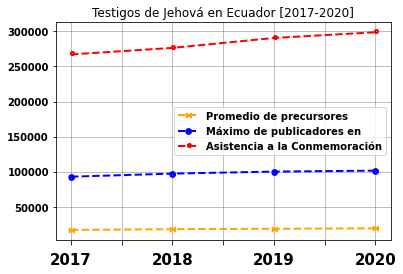

In [133]:
#ANY 'país' ANALIZE
pais='Ecuador' #ingresar COUNTRY

#CREATE DATAFRAMES FOR YEAR OF 'país'
years=['2017','2018','2019','2020']
for year in years:
    globals()['df'+year+pais]=globals()['df'+year].loc[pais]
    globals()['df'+year+pais]=globals()['df'+year].loc[pais]
    globals()['df'+year+pais]=globals()['df'+year].loc[pais]
    globals()['df'+year+pais]=globals()['df'+year].loc[pais]

#...FOR ALL RENAME INDEX
characters = "0126789"
years=['2017','2018','2019','2020']
for year in years:
    globals()['mc'+year]=globals()['df'+year].columns
    globals()['mc'+year+'n']=[]
    for cyear in globals()['mc'+year]:
        for char in characters:
            cyear=cyear.replace(char,"")
        globals()['mc'+year+'n'].append(cyear) #Array with columns-names without numbers (years)
    globals()['df'+year+pais]=globals()['df'+year+pais].rename(index={cyear:cyearn for (cyear,cyearn) in zip(globals()['mc'+year],globals()['mc'+year+'n'])})

#RENAME INDEX WITH DISTINCT NAMES
globals()['df2017'+pais]=globals()['df2017'+pais].rename(index={globals()['df2017'+pais].index[2]:'Un publicador por cada'}) #Change the name of a column
globals()['df2017'+pais]
globals()['df2018'+pais]=globals()['df2018'+pais].rename(index={globals()['df2018'+pais].index[2]:'Un publicador por cada'}) #Change the name of a column
globals()['df2018'+pais]
globals()['df2019'+pais]
globals()['df2020'+pais]

#DATAFRAME NEW WHOSE INDEX ARE A YEARS (FOR ONLY ONE COUNTRY)
globals()['df'+pais]=pd.DataFrame(index=['2017','2018','2019','2020'],data=[globals()['df2017'+pais],globals()['df2018'+pais],globals()['df2019'+pais],globals()['df2020'+pais]])
globals()['df'+pais]

#PLOT
globals()['df'+pais]['Promedio de precursores'].plot(kind='line',color='orange',marker=r'$\bowtie$',linestyle='dashed',legend='Max. Pub')
globals()['df'+pais]['Máximo de publicadores en '].plot(kind='line',color='blue',marker=r'$\Theta$',linestyle='dashed',legend='Max. Pub')
globals()['df'+pais]['Asistencia a la Conmemoración'].plot(kind='line',color='red',marker=r'$\circ$',linestyle='dashed',legend='Max. Pub')
#globals()['df'+'Colombia']['Promedio de precursores'].plot(kind='line',color='green',marker=r'$\bowtie$',linestyle='dashed',legend='Max. Pub') #to compare. Optimize!!!
plt.title('Testigos de Jehová en '+pais+' ['+years[0]+'-'+years[3]+']')
plt.grid(visible=True)
plt.show()

In [ ]:
#-----------------BELLOW:MORE OPERATIONS------------------#

In [ ]:
#OPERATIONS WITH ONLY ONE DATAFRAME

df.describe() #quit exponential notation

#df[mc[0]] #values of column="Habitantes"

df[mc[1:4]] #values of columns="Habitantes","Máximo de publicadores en 2020","Un publicador por cada"

df[[mc[1],mc[6]]] #values of columns="Habitantes", "Número de bautizados en 2020"

df.loc[0] #values of row=0

df.loc[0:3] #values of rows=0,1,2,3 #if index changes (manually), use iloc['country-example']

df.loc[[0,2],[mc[0],mc[3]]] #values of intersection rows[0,2] n' columns[0,3], answer the question value of variable 'Un publicador por cada' by countries 'Albania' and 'Andorra'

df[df[mc[6]]<1000]#170countries with less 1000 'Número de bautizados en 2020'

df[(df[mc[6]]<1000) & (df[mc[1]]>1000000)]#93countries with less than 1000 'Número de bautizados en 2020' y more than 1000000 'Habitantes'

df[(df[mc[6]]<1000) & (df[mc[1]]>1000000) & (df[mc[0]].str.contains('a'))]#80countries with less than 1000 'Número de bautizados en 2020' y more than 1000000 'Habitantes' whose 'Country' name contains a

def pubMinusPrec(roW):
    result=roW[mc[4]]-roW[mc[7]]
    return result

df["publicadores no precursores"]=df.apply(pubMinusPrec,axis=1) #Calculated column witg operation row by row. def() and apply()
df

In [ ]:
#When index rows is default, loc is similar to iloc. loc search for created index, iloc search for numeric index
#df=pd.DataFrame(df, index_col=mc[0]) #argument index_col it uses when pd.read csv or excel
df.index

for i in range(0,df.shape[0]):
    df=df.rename(index={df.index[i]:df[mc[0]][i]})
df.drop(columns=mc[0])

df.loc['Colombia']

In [ ]:
#Group by '% de aumento sobre 2019' mean column 'habitantes', max column 'Máximo publicadores en 2020' (aggregation function)
group=df.groupby(mc[5]).agg({
    mc[1]:'mean',
    mc[2]:'max'
}).head()
group

In [ ]:
#!pip install matplotlib
import matplotlib.pyplot as plt

group[mc[1]].plot(kind='bar')
plt.show()

In [ ]:
df[mc[4]] #column 'promedio de publicadores', axis x in scatter bellow, independent variable(?)
df[mc[9]] #column 'asistencia conmemoración', axis y in scatter bellow, dependent variable(?)

#inspect relation(?)
df.plot(kind='scatter',x=mc[4],y=mc[9]) #correlation (head and tail?)

In [ ]:
#OPERATIONS WITH ONLY ONE DATAFRAME

def pubPerPrec(roW):
    try:
        result=roW[mc[4]]/roW[mc[7]]
    except ZeroDivisionError:
        result='NaN' #Management div by zero
    return result

df["publicadores/precursores"]=df.apply(pubPerPrec,axis=1) #Calculated column witg operation row by row. def() and apply()
df[df["publicadores/precursores"]=='NaN']

In [77]:
group.to_csv("out.csv") #export

In [83]:
#build a dataframe as a dictionaries array. Each dictionary is a row
data=[
    {
        'column 1':'A',
        'column 2':1,
        'column 3':True   
    },
    {
        'column 1':'B',
        'column 2':2,
        'column 3':False   
    },
    {
        'column 1':'C'+'-',
        'column 2':3+2,
        'column 3':True or False   
    }
]
dataFrame=pd.DataFrame(index=['i1','i2','i3'],data=data)
dataFrame

,column 1,column 2,column 3
i1,A,1,True
i2,B,2,False
i3,C-,5,True


In [ ]:
#https://miktex.org/download for Download as pdf via LaTex